# April 2023 Data Challenge

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [44]:
from pathlib import Path
import shutil
import os

### File importation

In [45]:
# windows path
#os.chdir(r"C:\Users\code\Downloads\code\april23_data_challenge\CSV")

In [51]:
# linux path
os.chdir('./CSV')

In [ ]:
#content = Path.iterdir(Path.cwd())

for file in content:
    old_filename = file.name
    if 'olist_' in old_filename:
        new_filename = old_filename.replace('olist_', '').replace('_dataset', '')
        shutil.move(old_filename, new_filename)

In [52]:
content = Path.iterdir(Path.cwd())

In [53]:
dataframes = {}
for file in content:
    if file.is_file():
        dataframes[file.stem] = pd.read_csv(file.name)

In [54]:
print(*dataframes.keys(), sep='\n')

sellers
order_items
order_reviews
order_payments
orders
products
geolocation
customers
product_category_name_translation


# <span style='color:red'>TODO: check if datasets are clean</span>

# 1: What is the total revenue generated by Olist, and how has it changed over time?

In [55]:
df_orders = dataframes['orders']
df_items = dataframes['order_items']

### Dates manipulation

Orders dataframe contains dates. Let's check if the dtype is correct

In [56]:
df_orders.dtypes

order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
dtype: object

In [57]:
date_cols = 'order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date'.split(', ')
date_cols

['order_purchase_timestamp',
 'order_approved_at',
 'order_delivered_carrier_date',
 'order_delivered_customer_date',
 'order_estimated_delivery_date']

In [58]:
for col in date_cols:
    df_orders[col] = pd.to_datetime(df_orders[col])

In [59]:
df_orders.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

### order_items dataframe contains dates. Let's check if the dtype is correct

In [60]:
df_items.dtypes

order_id                object
order_item_id            int64
product_id              object
seller_id               object
shipping_limit_date     object
price                  float64
freight_value          float64
dtype: object

In [61]:
df_items.shipping_limit_date = pd.to_datetime(df_items.shipping_limit_date)

In [62]:
df_revenues = pd.merge(left=df_orders, right=df_items, on='order_id', how='left')

In [63]:
df_revenues.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date',
       'price', 'freight_value'],
      dtype='object')

In [64]:
df_revenues.duplicated().sum()

0

In [106]:
df_revenues.order_status.unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'created', 'approved'], dtype=object)

In order to work out the total revenue, I exclude orders with status: cancelled or unavailable.

In [114]:
revenues_by_order = (
    df_revenues[~ df_revenues.order_status.isin(['canceled', 'unavailable']) ]
    .groupby('order_id')['price']
    .sum(numeric_only=True)
    .to_frame()
    .rename(columns = {'price': 'revenue'})
)

In [115]:
revenues_by_order

,revenue
order_id,
00010242fe8c5a6d1ba2dd792cb16214,58.90
00018f77f2f0320c557190d7a144bdd3,239.90
000229ec398224ef6ca0657da4fc703e,199.00
00024acbcdf0a6daa1e931b038114c75,12.99
00042b26cf59d7ce69dfabb4e55b4fd9,199.90
...,...
fffc94f6ce00a00581880bf54a75a037,299.99
fffcd46ef2263f404302a634eb57f7eb,350.00
fffce4705a9662cd70adb13d4a31832d,99.90


In [67]:
total_revenues = revenues_by_order.sum()
total_revenues

revenue    13591643.7
dtype: float64

### Working with purchase dates

In [68]:
dates = df_revenues.order_approved_at.dt.date
dates = dates[dates.notnull()]

In [69]:
dates.min(), dates.max()

(datetime.date(2016, 9, 15), datetime.date(2018, 9, 3))

The oldest order was made on 2016 and the latest on 2018.

I will aggregate the orders by quarters.

In [70]:
quarterly_revenue = df_revenues.set_index('order_approved_at')

In [71]:
quarter_total_revenue = quarterly_revenue.resample('3M', closed='left').price.sum().to_frame()
quarter_total_revenue = quarter_total_revenue.rename(columns = {'price' : 'total_revenue'})
quarter_total_revenue.index.name = 'quarter_date'
quarter_total_revenue

,total_revenue
quarter_date,
2016-11-30,49775.02
2017-02-28,351653.68
2017-05-31,1226090.95
2017-08-31,1494439.01
2017-11-30,2280243.60
2018-02-28,2528203.39
2018-05-31,3010811.75
2018-08-31,2648610.87
2018-11-30,145.00


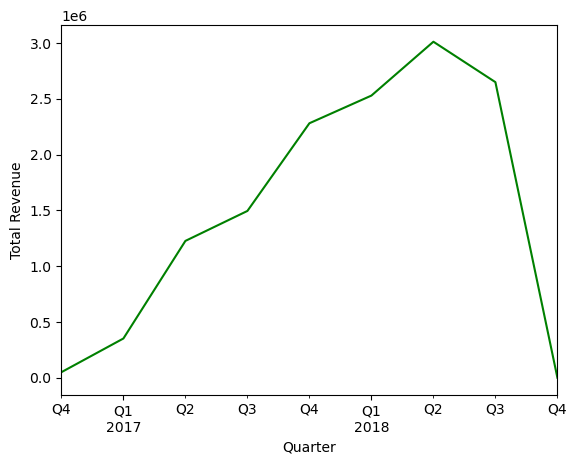

In [72]:
fig, ax = plt.subplots()
quarter_total_revenue.plot.line(color='green', ax = ax, legend=False)
ax.set_xlabel('Quarter')
ax.set_ylabel('Total Revenue')
plt.show()

# 2: How many orders were placed on Olist, and how does this vary by month or season?

In [73]:
valid_orders = df_orders[df_orders['order_status'] != 'canceled']

Number of orders placed by Olist:

In [74]:
valid_orders.order_id.nunique()

98816

In [75]:
df2 = valid_orders.set_index('order_approved_at')

In [76]:
orders_placed_monthly = df2.resample('M', closed='left').order_id.count()

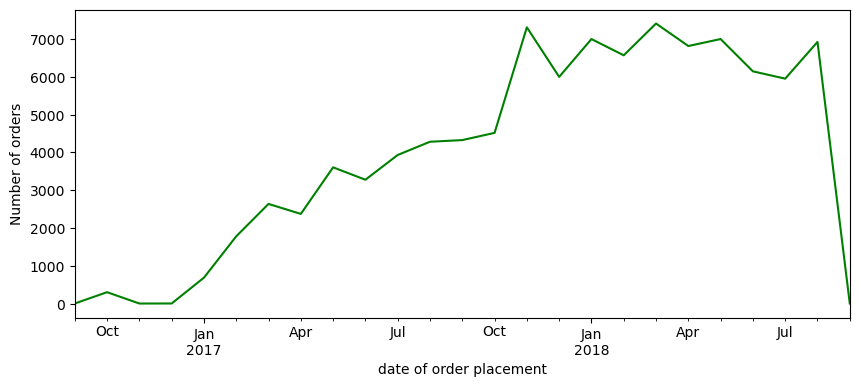

In [77]:
fig, ax = plt.subplots(figsize=(10,4))
orders_placed_monthly.plot.line(ax=ax, color='green')
ax.set_xlabel('date of order placement')
ax.set_ylabel('Number of orders')
plt.show()

# 3: What are the most popular product categories on Olist, and how do their sales volumes compare to each other?

In [78]:
df_items = dataframes['order_items']

In [79]:
df_items.sample(5)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
45482,674eb13687ba86abeaee12ece9ce0309,5,0ad6795586afdad1281b3884f2611ca6,bdae679a9b282249bc23b9b69dae9a99,2018-08-23 12:25:19,16.8,4.20
111594,fd79fe34d2fd6389d56e726bfc0bff4f,1,a95db8c4b3cfdf4a5d518e0d738e4374,c794dab4928dd97beb41d05514441e86,2018-05-14 04:35:34,27.3,7.39
94549,d66c390445566a6735c7a703c75e4e68,1,58816ce2ec224ea03aff8abe045f8407,955fee9216a65b617aa5c0531780ce60,2018-08-02 03:55:12,99.0,11.71
263,00ab210695a17fe10e6b23616ae5bc97,1,c6336fa91fbd87c359e44f5dca5a90ed,4c2b230173bb36f9b240f2b8ac11786e,2018-06-18 06:30:53,39.0,7.53
32588,49e16a61a02330e3982bcb6c57f39377,1,418d480693f2f01e9cf4568db0346d28,12b9676b00f60f3b700e83af21824c0e,2018-06-21 22:55:39,199.0,28.34


In [80]:
df_products = dataframes['products']

In [81]:
df_products.sample(5)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
8498,5b95b27af12b245754e70df7e16d53e1,bebes,36.0,126.0,1.0,900.0,50.0,8.0,40.0
17507,6972a2007571907bdd466492ffa86638,NaN,NaN,NaN,NaN,750.0,19.0,6.0,26.0
4840,4ce81153410b379f2ccab68653ca5fe4,moveis_decoracao,32.0,297.0,1.0,400.0,53.0,15.0,53.0
16705,eec68ed7d496bb2ee6aa0a69bb78acd2,papelaria,34.0,332.0,2.0,850.0,40.0,15.0,37.0
3018,84b07ca699022a5dde105eddb4aac42c,beleza_saude,35.0,1830.0,1.0,3400.0,21.0,25.0,20.0


In [82]:
df_translation = dataframes['product_category_name_translation']
df_translation

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor
...,...,...
66,flores,flowers
67,artes_e_artesanato,arts_and_craftmanship
68,fraldas_higiene,diapers_and_hygiene
69,fashion_roupa_infanto_juvenil,fashion_childrens_clothes


In [83]:
df = pd.merge(df_orders, df_items, on='order_id', how='left')
df = pd.merge(df, df_products, on='product_id', how='left')
df = pd.merge(df, df_translation, on='product_category_name', how='left')

In [84]:
df.sample().T

,58712
order_id,71cbc9238e1177bbe3e484d098875aee
customer_id,0140bb3a2e24b8dd7a341eaf707b440e
order_status,delivered
order_purchase_timestamp,2018-02-16 07:59:09
order_approved_at,2018-02-17 03:47:44
order_delivered_carrier_date,2018-02-20 17:17:11
order_delivered_customer_date,2018-02-28 11:33:28
order_estimated_delivery_date,2018-03-08 00:00:00
order_item_id,1.0
product_id,777d2e438a1b645f3aec9bd57e92672c


In [85]:
categories= df[['order_id', 'product_id', 'price', 'product_category_name_english']]

In [86]:
categories_count = categories.groupby('product_category_name_english').agg({'order_id': 'count', 'price' : sum}).sort_values('order_id', ascending=False)
categories_count = categories_count.rename(columns = {'order_id': 'total_units_ordered', 'price': 'total_revenue'})
categories_count.index = [i.replace('_', ' ').strip() for i in categories_count.index]

In [87]:
categories_count

,total_units_ordered,total_revenue
bed bath table,11115,1036988.68
health beauty,9670,1258681.34
sports leisure,8641,988048.97
furniture decor,8334,729762.49
computers accessories,7827,911954.32
...,...,...
arts and craftmanship,24,1814.01
la cuisine,14,2054.99
cds dvds musicals,14,730.00
fashion childrens clothes,8,569.85


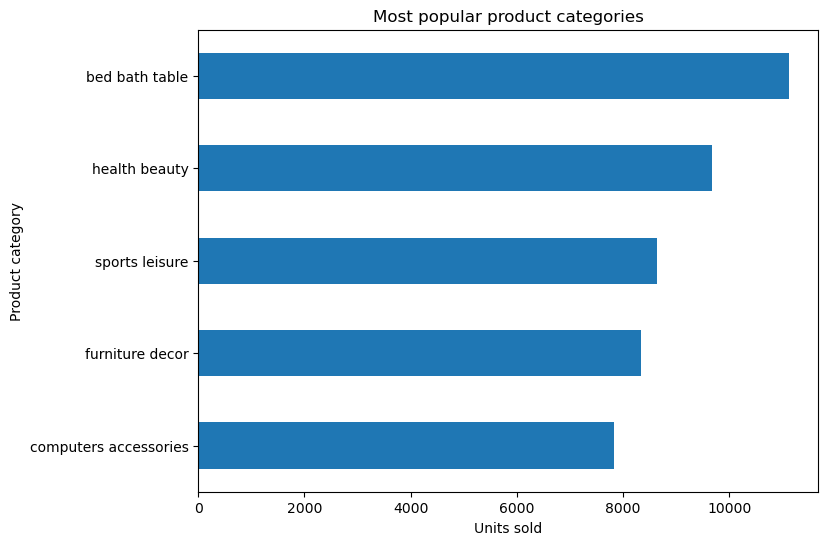

In [88]:
fig, ax = plt.subplots(figsize=(8,6))
data = categories_count.total_units_ordered[:5].sort_values(ascending=True)
data.plot.barh()
ax.set_xlabel('Units sold')
ax.set_ylabel('Product category')
ax.set_title('Most popular product categories')
plt.show()

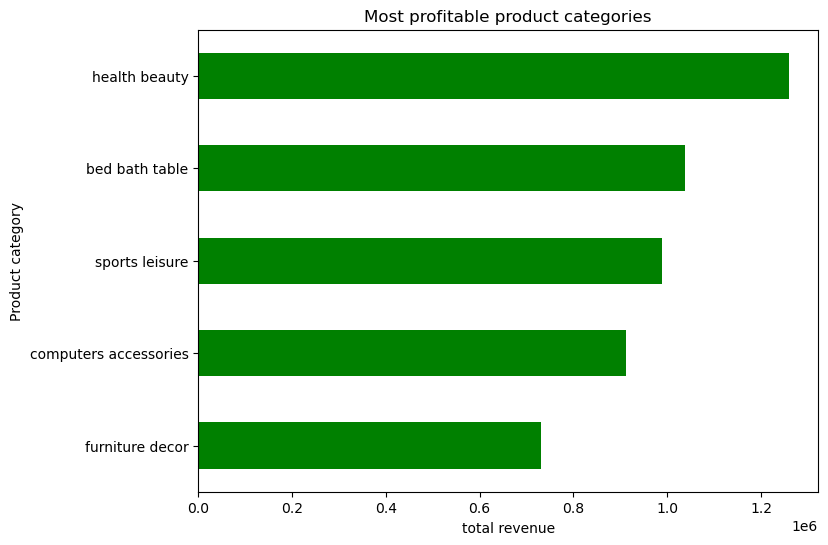

In [89]:
fig, ax = plt.subplots(figsize=(8,6))
data = categories_count.total_revenue[:5].sort_values()
data.plot.barh(color='green')
ax.set_xlabel('total revenue')
ax.set_ylabel('Product category')
ax.set_title('Most profitable product categories')
plt.show()

# 4: What is the average order value (AOV) on Olist, and how does this vary by product category or payment method?

Average order value is:

In [90]:
round(revenues_by_order.mean(), 2)

revenue    136.68
dtype: float64

In [91]:
order_mean_by_prod_category = df.groupby('product_category_name_english').price.mean().round(2).sort_values(ascending=False)
order_mean_by_prod_category

product_category_name_english
computers                                1098.34
small_appliances_home_oven_and_coffee     624.29
home_appliances_2                         476.12
agro_industry_and_commerce                342.12
musical_instruments                       281.62
                                          ...   
food_drink                                 54.60
cds_dvds_musicals                          52.14
diapers_and_hygiene                        40.19
flowers                                    33.64
home_comfort_2                             25.34
Name: price, Length: 71, dtype: float64

In [92]:
revenues_by_payment_method = (
df_revenues[['order_id', 'order_status', 'price']]
.merge(dataframes['order_payments'], on='order_id', how ='left')
.drop(['payment_sequential', 'payment_installments'], axis=1)
)
# get only those orders which weren't eventually canceled
revenues_by_payment_method = revenues_by_payment_method[revenues_by_payment_method.order_status != 'canceled']

In [93]:
average_revenue_by_pay_method = revenues_by_payment_method.groupby('payment_type').price.mean().sort_values(ascending=False).round(2)
average_revenue_by_pay_method.index = [i.replace('_', ' ') for i in average_revenue_by_pay_method.index ]

In [94]:
average_revenue_by_pay_method

credit card    126.21
debit card     107.56
voucher        104.55
boleto         104.41
Name: price, dtype: float64

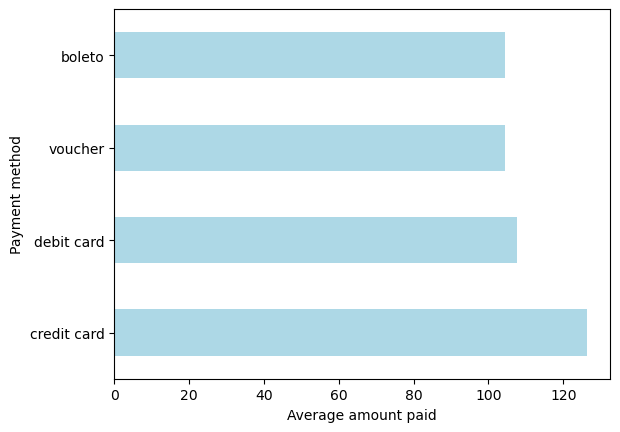

In [95]:
fig,ax = plt.subplots()
average_revenue_by_pay_method.plot.barh(color='lightblue', ax=ax)
ax.set_xlabel('Average amount paid')
ax.set_ylabel('Payment method')
plt.show()

# 5: How many sellers are active on Olist, and how does this number change over time?

In [96]:
df_sellers = dataframes['sellers']

In [97]:
sellers = pd.merge(df_orders, df_items, on='order_id', how='left')

In [98]:
sellers = sellers.merge(df_sellers, on='seller_id', how='left')

I will downsample the data to generate a time series and group the data by quarters. 

In [99]:
sellers = sellers.set_index('order_approved_at')

In [100]:
quarterly_orders = sellers.resample('3M')

In [101]:
sellers_count = (
    quarterly_orders.seller_id
    .unique()
    .apply(lambda x : len(x) )
    )
sellers_count.name = 'sellers_count_by_quarter'
sellers_count.index.name = 'quarter_date'

In [102]:
sellers_count

quarter_date
2016-09-30       1
2016-12-31     146
2017-03-31     658
2017-06-30     811
2017-09-30    1011
2017-12-31    1267
2018-03-31    1382
2018-06-30    1679
2018-09-30    1629
Name: sellers_count_by_quarter, dtype: int64

The number of sellers wich made a sale on the last quarter of
the available data is:

In [103]:
last_active_sellers_count = sellers_count[-1]
last_active_sellers_count

1629

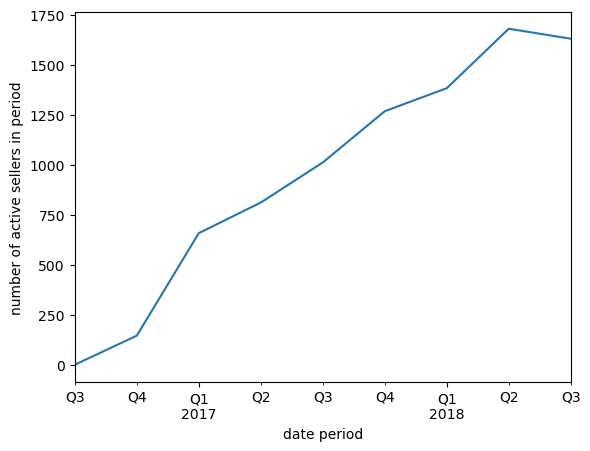

In [104]:
fig, ax = plt.subplots()
sellers_count.plot.line()
ax.set_xlabel('date period')
ax.set_ylabel('number of active sellers in period')
plt.show()